## Show difference between 3 subjects in keyboard dataset

In [50]:
from skbio.stats.ordination import pcoa
from scipy.spatial.distance import pdist
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from q2_anomaly_detection.datasets import DietInterventionStudy
from q2_anomaly_detection.benchmark import Benchmark
%matplotlib inline

In [51]:
RANDOM_SEED = 825
RAREFACTION_DEPTH = 4000
# qiita study 232 with trimming to 90 bp and pick closed reference on 97 otus tree
dataset = DietInterventionStudy('data/diet_intervention')

Files already downloaded and verified


In [52]:
TRAINING_CATEGORY = 'host_subject_id_for_plant'
TRUTH_CATEGORY = 'host_subject_id'
INTEREST_VARIABLE = 'diet'

In [53]:
def construct_category(metadata):
    metadata['host_subject_id_for_plant'] = np.nan
    plant_samples = metadata.index[metadata.diet == 'Plant']
    metadata.loc[:, 'host_subject_id_for_plant'].loc[plant_samples] = metadata.host_subject_id[
        plant_samples].to_numpy()


def subset_metadata(metadata_all, table):
    table_ids = set(table.ids())

    # also remove anything that does not have more than RAREFACTION_DEPTH counts
    #  in both 'Plant' and 'Meat'
    table_sum = table.sum(axis='sample')

    insufficient_count_ids = table.ids('sample')[table_sum < RAREFACTION_DEPTH]

    table_ids -= set(insufficient_count_ids)


    metadata = metadata_all.query('host_common_name == "human" & sample_name in @table_ids &'
                                  'diet in ["Plant", "Animal"]'
                                 )
    
    diets_present = metadata[['host_subject_id', 'diet']].groupby('host_subject_id').agg(set)
    diets_sufficient = diets_present.apply(lambda diets: diets >= {'Plant', 'Animal'})
    sufficient_ids = diets_sufficient.loc[diets_sufficient['diet']].index
    
    metadata = metadata.query('host_subject_id in @sufficient_ids')

    return metadata

In [54]:
iso = IsolationForest(contamination="auto")
lof = LocalOutlierFactor(novelty=True,
                         contamination="auto",
                        )
lof_jaccard = LocalOutlierFactor(novelty=True,
                         contamination="auto",
                         metric='jaccard',
                        )
ocsvm = OneClassSVM(gamma='auto')

In [55]:
# CONVENTION: anomaly scores should be transformed onto (0, 1) where 1 is
#  least anomalous and 0 is the most anomalous
models = {
    'IF': {
        'model': iso,
    },
    'LOF': {
        'model': lof,
    },
    'LOF-jaccard': {
        'model': lof_jaccard,
    },
    'ocsvm': {
        'model': ocsvm,
    },
}

In [56]:
table = dataset['table']

In [57]:
table.shape

(7107, 408)

In [58]:
metadata_all = dataset['metadata']

In [59]:
metadata = subset_metadata(metadata_all, table)

In [60]:
metadata = metadata.set_index('sample_name')

In [61]:
metadata[INTEREST_VARIABLE].unique()


array(['Plant', 'Animal'], dtype=object)

In [62]:
construct_category(metadata)

/Users/garmstro/miniconda3/envs/anomaly-detection-qiime2-2020.11/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [63]:
table.filter(metadata.index, axis='sample')

7107 x 210 <class 'biom.table.Table'> with 161609 nonzero entries (10% dense)

In [64]:
np.random.seed(RANDOM_SEED)
subtable = table.subsample(RAREFACTION_DEPTH)
submetadata = metadata.loc[metadata.index.isin(subtable.ids('sample'))]

In [65]:
subtable.shape

(2609, 210)

In [66]:
study_ids = subtable.ids('sample')

/Users/garmstro/miniconda3/envs/anomaly-detection-qiime2-2020.11/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


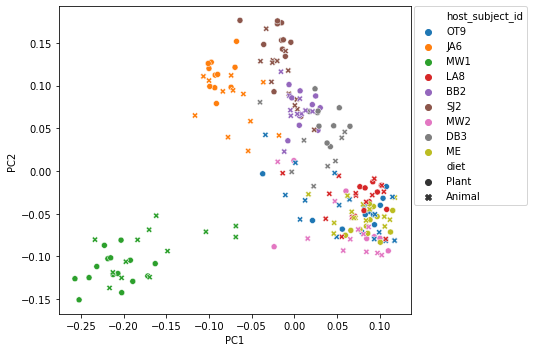

In [67]:
dm = pdist(subtable.matrix_data.todense().transpose(), metric='jaccard')

pcoa_results = pcoa(dm)

pcoa_results.samples.index = study_ids

pcoa_with_metadata = pcoa_results.samples.join(metadata)

plt.subplots(figsize=(10, 5))
ax = sns.scatterplot('PC1', 'PC2',
                     hue=TRUTH_CATEGORY,
                     style=INTEREST_VARIABLE,
                     data=pcoa_with_metadata
                     )
ax.set_aspect('equal')
plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)
plt.tight_layout()

## Show the results of an anomaly detection algorithm of one class v. rest


In [68]:
submetadata.shape

(210, 42)

In [69]:
submetadata.groupby([TRUTH_CATEGORY, 'diet']).agg('count')

collection_date_publication  collection_time  \
host_subject_id diet                                                   
BB2             Animal                           10               10   
                Plant                            10               10   
DB3             Animal                            8                8   
                Plant                            10               10   
JA6             Animal                           12               12   
                Plant                            11               11   
LA8             Animal                           14               14   
                Plant                            10               10   
ME              Animal                           14                0   
                Plant                            12                0   
MW1             Animal                           13               13   
                Plant                            15               14   
MW2             Animal                           12               10   
                Plant                             7                7   
OT9             Animal                           15               13   
                Plant                            12                0   
SJ2             Animal                           13               13   
                Plant                            12               12   

                        collection_timestamp  country  day  description  \
host_subject_id diet                                                      
BB2             Animal                    10       10   10           10   
                Plant                     10       10   10           10   
DB3             Animal                     8        8    8            8   
                Plant                     10       10   10           10   
JA6             Animal                    12       12   12           12   
                Plant                     11       11   11           11   
LA8             Animal                    14       14   14           14   
                Plant                     10       10   10           10   
ME              Animal                    14       14   14           14   
                Plant                     12       12   12           12   
MW1             Animal                    13       13   13           13   
                Plant                     15       15   15           15   
MW2             Animal                    12       12   12           12   
                Plant                      7        7    7            7   
OT9             Animal                    15       15   15           15   
                Plant                     12       12   12           12   
SJ2             Animal                    13       13   13           13   
                Plant                     12       12   12           12   

                        elevation  empo_1  empo_2  empo_3  ...  place  \
host_subject_id diet                                       ...          
BB2             Animal         10      10      10      10  ...     10   
                Plant          10      10      10      10  ...     10   
DB3             Animal          8       8       8       8  ...      8   
                Plant          10      10      10      10  ...     10   
JA6             Animal         12      12      12      12  ...     12   
                Plant          11      11      11      11  ...     10   
LA8             Animal         14      14      14      14  ...     14   
                Plant          10      10      10      10  ...     10   
ME              Animal         14      14      14      14  ...     14   
                Plant          12      12      12      12  ...     12   
MW1             Animal         13      13      13      13  ...     13   
                Plant          15      15      15      15  ...     15   
MW2             Animal         12      12      12      12  .

In [70]:
benchmark = Benchmark(models)
all_results = benchmark.benchmarking_loop(subtable, submetadata, TRUTH_CATEGORY, TRAINING_CATEGORY)



/Users/garmstro/miniconda3/envs/anomaly-detection-qiime2-2020.11/lib/python3.6/site-packages/sklearn/neighbors/_lof.py:277: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/garmstro/miniconda3/envs/anomaly-detection-qiime2-2020.11/lib/python3.6/site-packages/sklearn/neighbors/_lof.py:277: UserWarning: n_neighbors (20) is greater than the total number of samples (12). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/garmstro/miniconda3/envs/anomaly-detection-qiime2-2020.11/lib/python3.6/site-packages/sklearn/neighbors/_lof.py:277: UserWarning: n_neighbors (20) is greater than the total number of samples (12). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/garmstro/miniconda3/envs/anomaly-detection-qiime2-2020.11/lib/python3.6/site-packages/sklearn/neigh

/Users/garmstro/miniconda3/envs/anomaly-detection-qiime2-2020.11/lib/python3.6/site-packages/sklearn/neighbors/_lof.py:277: UserWarning: n_neighbors (20) is greater than the total number of samples (10). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/garmstro/miniconda3/envs/anomaly-detection-qiime2-2020.11/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/garmstro/miniconda3/envs/anomaly-detection-qiime2-2020.11/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


In [71]:
res_df = all_results.long_form()

In [72]:
res_with_pc = res_df.reset_index().join(
    pcoa_results.samples[['PC1', 'PC2', 'PC3']], on='sample_id'
).join(
    metadata[[INTEREST_VARIABLE]], on='sample_id'
)

/Users/garmstro/miniconda3/envs/anomaly-detection-qiime2-2020.11/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


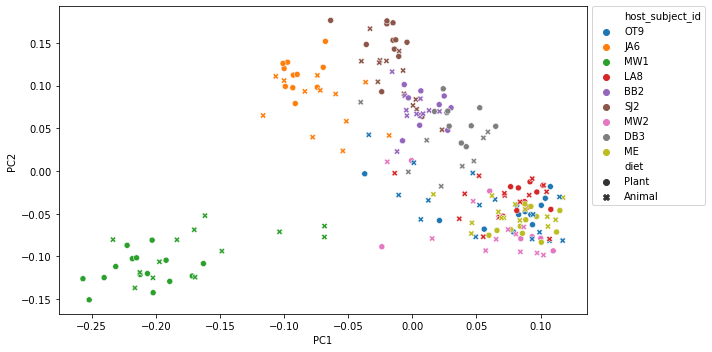

In [73]:
plt.subplots(figsize=(10, 5))
sns.scatterplot('PC1', 'PC2',
                hue='host_subject_id',
                style=INTEREST_VARIABLE,
                data=pcoa_with_metadata)
plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)
plt.tight_layout()

In [74]:
sns.set(font_scale=1.5)

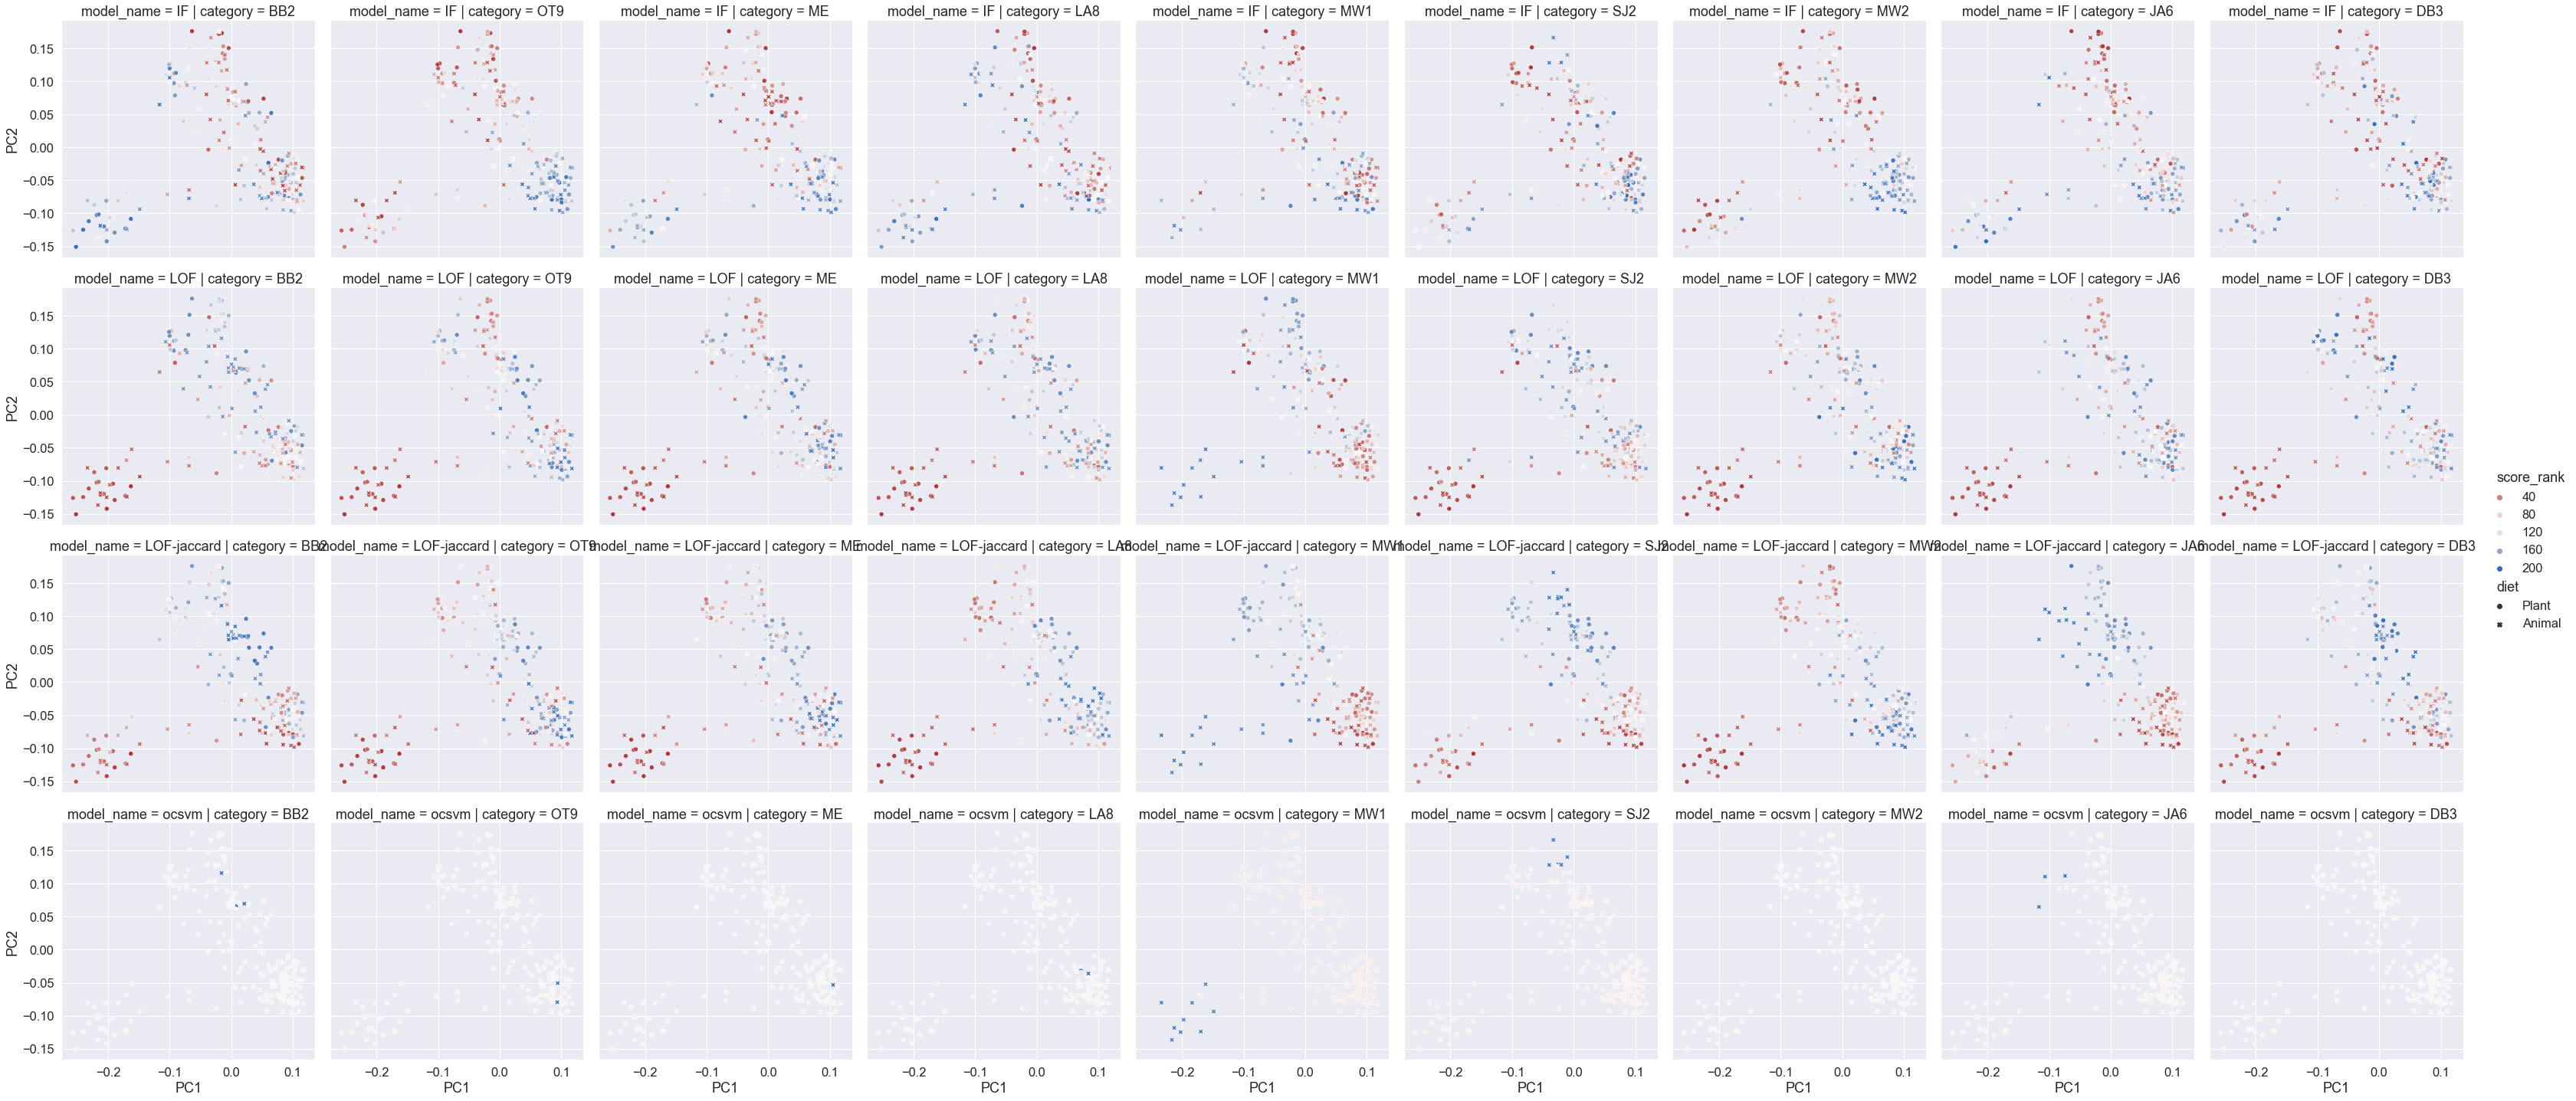

In [75]:
ax = sns.relplot(x='PC1', y='PC2',
            data=res_with_pc,
            col='category',
            row='model_name',
            hue='score_rank',
            palette='vlag_r',
            style=INTEREST_VARIABLE,
            aspect=1,
           )

In [79]:
all_results.short_form().sort_values('avg_prec', ascending=False)


,model_name,category,roc_auc,avg_prec
21,LOF-jaccard,LA8,1.000000,1.000000
13,LOF,MW1,1.000000,1.000000
23,LOF-jaccard,SJ2,0.998753,0.999913
24,LOF-jaccard,MW2,0.998255,0.999890
25,LOF-jaccard,JA6,0.997772,0.999859
22,LOF-jaccard,MW1,0.997887,0.999850
18,LOF-jaccard,BB2,0.976842,0.998682
19,LOF-jaccard,OT9,0.949362,0.995392
26,LOF-jaccard,DB3,0.906250,0.995157
20,LOF-jaccard,ME,0.942158,0.994674
